In [ ]:
# prompt: how to clone in to a git link

!git clone https://github.com/raghavendra-me/No-gPU-TRYON.git


Cloning into 'No-gPU-TRYON'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 121 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (121/121), 266.40 KiB | 4.76 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
cd /content/No-gPU-TRYON

/content/No-gPU-TRYON


In [ ]:
# cd /content/cp-VTryon-plus-Flask-App/tryon_utils

In [ ]:
pwd

'/content/No-gPU-TRYON'

In [ ]:
ls

cloth_mask.py  dataloaders/   networks/         __pycache__/     visualization.py
cp_dataset.py  image_mask.py  networks_gmm.py   sync_batchnorm/
data/          inference.py   openpose_json.py  test.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
#imports
from cloth_mask import cloth_masking
# from openpose_json import *
from image_mask import make_body_mask

In [ ]:
!pip install ipywidgets
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [ ]:
text_file_path = "data/test_pairs.txt"
cloth_mask_path = "data/test/cloth-mask"
image_mask_path = "data/test/image-mask"
pose_path = "data/test/pose"
image_parse_path = "data/test/image-parse"
#and global variables are
# image_filename = None
# cloth_filename = None
# image_path = None
# cloth_path = None

In [ ]:
#default path

def edit_text_file(image_filename, cloth_filename, text_file_path):
    try:
        with open(text_file_path, 'w') as f:
            f.write(f"{image_filename} {cloth_filename}\n")
        print(f"Updated {text_file_path} with {image_filename} {cloth_filename}")
    except Exception as e:
        print(f"Error updating {text_file_path}: {str(e)}")

In [ ]:
import cv2
import time
import numpy as np
from random import randint
import argparse
import json

#image1 = cv2.imread("000010_0.jpg")
protoFile = "/content/drive/MyDrive/vton_plus_thing/coco/pose_deploy_linevec.prototxt"
weightsFile = "/content/drive/MyDrive/vton_plus_thing/coco/pose_iter_440000.caffemodel"
nPoints = 18

# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

# generate target image pose key points
def generate_pose_keypoints(img_file):
    '''
    Generates pose keypoints
    Input: Person Image
    Output: Writes json file with keypoints(shape: 18*3 = 54)
    '''

    image1 = cv2.imread("data/test/image/"+ img_file)
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    #if args.device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    print("Time Taken in forward pass = {}".format(time.time() - t))

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)


    frameClone = image1.copy()
    pose_keypoints = []
    for i in range(nPoints):
        if detected_keypoints[i] ==[]:
            pose_keypoints.append(0)
            pose_keypoints.append(0)
            pose_keypoints.append(0)

        for j in range(len(detected_keypoints[i])):
            pose_keypoints.append(detected_keypoints[i][j][0])
            pose_keypoints.append(detected_keypoints[i][j][1])
            pose_keypoints.append(detected_keypoints[i][j][2].astype(float))

    json_data = {"version": 1.0, "people": [{
        "face_keypoints": [],
        "pose_keypoints":pose_keypoints,
        "hand_right_keypoints": [],
        "hand_left_keypoints": []
        }]}

    # write json file
    json_file = img_file.split('.jpg')[0] + "_keypoints.json"
    with open("data/test/pose/"+ json_file, 'w') as outfile:
        json.dump(json_data, outfile)
    return "written keypoints json file"

In [ ]:
def display_generated_tryon(image_filename):
    tryon_image_path = f"/content/No-gPU-TRYON/result/TOM/test/try-on/{image_filename}"
    tryon_image = Image.open(tryon_image_path).resize((192, 256))
    display(tryon_image)


In [ ]:
from PIL import Image
import io
import os

In [ ]:
# Function to handle try-on generation
def on_generate_tryon_click(b):
    global image_filename, cloth_filename, image_path, cloth_path

    if upload_image_btn.value and upload_cloth_btn.value:
        # Handle image upload
        for name, file_info in upload_image_btn.value.items():
            image_filename = name
            image = Image.open(io.BytesIO(file_info['content'])).resize((192, 256))
            display(image)
            # Save image to data/test/image directory
            image_path = os.path.join('data/test/image', image_filename)
            image.save(image_path)

        # Handle cloth upload
        for name, file_info in upload_cloth_btn.value.items():
            cloth_filename = name
            cloth = Image.open(io.BytesIO(file_info['content'])).resize((192, 256))
            display(cloth)
            # Save cloth to data/tes  t/cloth directory
            cloth_path = os.path.join('data/test/cloth', cloth_filename)
            cloth.save(cloth_path)

    #all the actual implementation of the data_preprocessing and manipulation
    #editing the text file- test_pairs.txt
    edit_text_file(image_filename, cloth_filename, text_file_path)

    #generating cloth-mask
    cloth_masking(cloth_path, os.path.join(cloth_mask_path, cloth_filename))
    # cloth_masking(image_path, os.path.join(cloth_mask_path, cloth_filename))

    #generating pose
    pose_keypoints = generate_pose_keypoints(image_filename)

    #generating image_parse
    print("image_parse")
    # !python inference.py --loadmodel checkpoints/inference.pth --img_path " + image_filename + " --output_path image_parse_path --output_name "+ filename_person
    !python inference.py --loadmodel /content/drive/MyDrive/vton_plus_thing/network/inference.pth --img_path {image_filename} --output_path {image_parse_path} --output_name {image_filename}

    #generating image_mask
    seg_file = image_filename.replace(".jpg", ".png")
    make_body_mask(image_filename, seg_file)

    #invking gmm
    perform_gmm()

    #invoking handling
    directory_handle()

    #invoking tom
    perform_tom()

    display_generated_tryon(image_filename)






In [ ]:
def perform_gmm():
  #!python3 json.py41
  !python test.py --name GMM --stage GMM --workers 2 --datamode test --data_list test_pairs.txt --checkpoint /content/drive/MyDrive/vton_plus_thing/checkpoints/GMM/gmm_final.pth
  # !python test.py --name TOM --stage TOM --workers 4 --datamode test --data_list test_pairs.txt --checkpoint /content/drive/MyDrive/vton_plus_thing/checkpoints/TOM/tom_final.pth

In [ ]:
def directory_handle():
  import shutil
  import os

  src_warp_cloth = '/content/No-gPU-TRYON/result/GMM/test/warp-cloth'
  src_warp_mask = '/content/No-gPU-TRYON/result/GMM/test/warp-mask'
  dst_warp_cloth = '/content/No-gPU-TRYON/data/test/warp-cloth'
  dst_warp_mask = '/content/No-gPU-TRYON/data/test/warp-mask'

  for file_name in os.listdir(src_warp_cloth):
      shutil.copy(os.path.join(src_warp_cloth, file_name), dst_warp_cloth)

  for file_name in os.listdir(src_warp_mask):
      shutil.copy(os.path.join(src_warp_mask, file_name), dst_warp_mask)


In [ ]:
def perform_tom():
  !python test.py --name TOM --stage TOM --workers 4 --datamode test --data_list test_pairs.txt --checkpoint /content/drive/MyDrive/vton_plus_thing/checkpoints/TOM/tom_final.pth


Button(button_style='success', description='Generate Try-On', style=ButtonStyle())

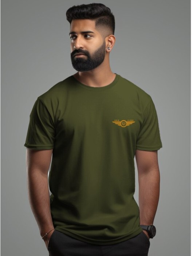

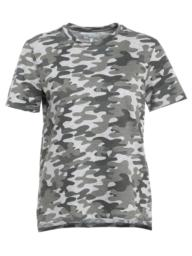

Updated data/test_pairs.txt with img.jpg 648.jpg
Saving data/test/cloth-mask/648.jpg
Using CPU device
Time Taken in forward pass = 6.128126382827759
Keypoints - Nose : [(78, 42, 0.6832949)]
Keypoints - Neck : [(94, 101, 0.5849036)]
Keypoints - R-Sho : [(47, 103, 0.49992484)]
Keypoints - R-Elb : [(40, 169, 0.5905006)]
Keypoints - R-Wr : [(46, 225, 0.6408364)]
Keypoints - L-Sho : [(139, 101, 0.56404203)]
Keypoints - L-Elb : [(145, 165, 0.65302825)]
Keypoints - L-Wr : [(144, 224, 0.59114623)]
Keypoints - R-Hip : [(69, 236, 0.25273052)]
Keypoints - R-Knee : []
Keypoints - R-Ank : []
Keypoints - L-Hip : [(121, 241, 0.28020924)]
Keypoints - L-Knee : []
Keypoints - L-Ank : []
Keypoints - R-Eye : [(73, 35, 0.798635)]
Keypoints - L-Eye : [(85, 35, 0.7306789)]
Keypoints - R-Ear : []
Keypoints - L-Ear : [(107, 41, 0.78276443)]
image_parse
Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3
load model: /content/drive/MyDrive/vton_plus_thing/network/

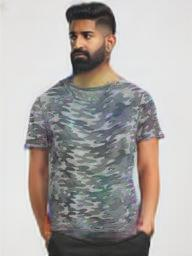

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

# Create upload buttons
upload_image_btn = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Do not allow multiple file uploads
)

upload_cloth_btn = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False  # Do not allow multiple file uploads
)

# Create generate try-on button
generate_tryon_btn = widgets.Button(
    description='Generate Try-On',
    disabled=False,
    button_style='success'
)

# Variables to store uploaded files
uploaded_image = None
uploaded_cloth = None

# Register the generate try-on button event
generate_tryon_btn.on_click(on_generate_tryon_click)

# Display the widgets
display(widgets.VBox([widgets.Label("Upload Image:"), upload_image_btn]))
display(widgets.VBox([widgets.Label("Upload Cloth:"), upload_cloth_btn]))
display(generate_tryon_btn)

In [ ]:
ls data/

grid.png  test/  test_pairs.txt


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing i

In [ ]:
# import gradio as gr
# from PIL import Image
# import os
# import io



# # Function to handle try-on generation
# def generate_tryon(image_file, cloth_file):
#     global image_filename, cloth_filename, image_path, cloth_path

#     image_filename = image_file.name
#     image = Image.open(image_file).resize((192, 256))
#     # Save image to data/test/image directory
#     image_path = os.path.join('data/test/image', image_filename)
#     image.save(image_path)

#     cloth_filename = cloth_file.name
#     cloth = Image.open(cloth_file).resize((192, 256))
#     # Save cloth to data/test/cloth directory
#     cloth_path = os.path.join('data/test/cloth', cloth_filename)
#     cloth.save(cloth_path)

#     # All the actual implementation of the data preprocessing and manipulation
#     edit_text_file(image_filename, cloth_filename, text_file_path)

#     # Generating cloth-mask
#     cloth_masking(cloth_path, os.path.join(cloth_mask_path, cloth_filename))

#     # Generating pose
#     pose_keypoints = generate_pose_keypoints(image_filename)

#     # Generating image_parse
#     os.system(f"python inference.py --loadmodel checkpoints/inference.pth --img_path {image_path} --output_path {image_parse_path} --output_name {image_filename}")

#     # Generating image_mask
#     seg_file = image_filename.replace(".jpg", ".png")
#     make_body_mask(image_filename, seg_file)

#     # Invoking GMM
#     perform_gmm()

#     # Invoking handling
#     directory_handle()

#     # Invoking TOM
#     perform_tom()

#     return display_generated_tryon(image_filename)

# # Define Gradio interface
# image_input = gr.Image(label="Upload Image", type="pil")
# cloth_input = gr.Image(label="Upload Cloth", type="pil")
# output = gr.Image(label="Generated Try-On")

# gr_interface = gr.Interface(fn=generate_tryon, inputs=[image_input, cloth_input], outputs=output, width = 224)
# gr_interface.launch()
